In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import pytorch_lightning as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule, DimmedSDOMLDataModule
from sdofm.pretraining import SAMAE

In [4]:
import omegaconf

cfg = omegaconf.OmegaConf.load("../experiments/pretrain_tiny_mae.yaml")
#cfg = omegaconf.OmegaConf.load("../experiments/default.yaml")

In [5]:
data_module = SDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache
    ))
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [6]:
ts = data_module.train_ds.aligndata
ts.shape

(145670, 9)

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
batch[0][1][0]

tensor([[-0.9629, -0.9629, -0.9629,  ..., -0.9629, -0.9629, -0.9629],
        [-0.9629, -0.9629, -0.9629,  ..., -0.9629, -0.9629, -0.9629],
        [-0.9629, -0.9629, -0.9629,  ..., -0.9629, -0.9629, -0.9629],
        ...,
        [-0.9629, -0.9629, -0.9629,  ..., -0.9629, -0.9629, -0.9629],
        [-0.9629, -0.9629, -0.9629,  ..., -0.9629, -0.9629, -0.9629],
        [-0.9629, -0.9629, -0.9629,  ..., -0.9629, -0.9629, -0.9629]])

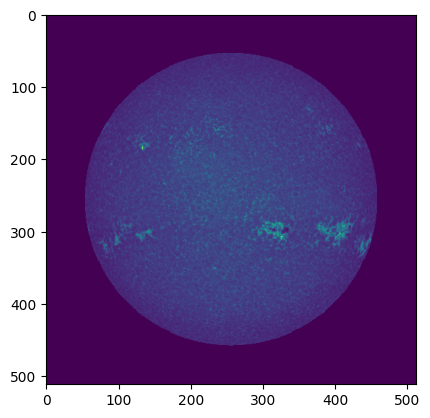

In [35]:
plt.imshow(batch[0][1][0])

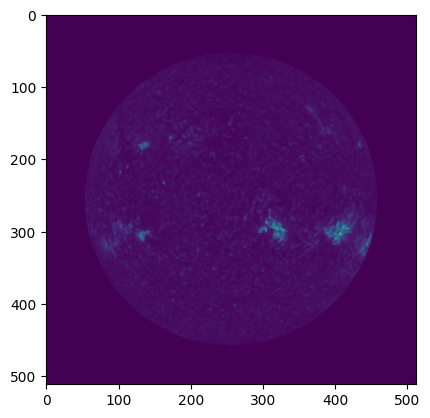

In [37]:
plt.imshow(batch[0][-3][0])

In [10]:
model = SAMAE(
     **cfg.model.mae,
     **cfg.model.samae,
     optimiser=cfg.model.opt.optimiser,
     lr=cfg.model.opt.learning_rate,
     weight_decay=cfg.model.opt.weight_decay,

 )



In [8]:
model.device

device(type='cpu')

In [ ]:
#model = SAMAE.load_from_checkpoint(
   # **cfg.model.mae,
   # **cfg.model.samae,
   # optimiser=cfg.model.opt.optimiser,
  #  lr=cfg.model.opt.learning_rate,
 #   weight_decay=cfg.model.opt.weight_decay,
#    checkpoint_path="/home/walsh/repos/SDO-FM/output/2024-04-17-00-41-29/0/sdofm/zy68fa00/checkpoints/epoch=3-step=48556.ckpt"
#)

In [ ]:
trainer = pl.Trainer(
    devices=1, accelerator=cfg.experiment.accelerator, max_epochs=cfg.model.opt.epochs
)
trainer.fit(model=model, datamodule=data_module)

In [27]:
for batch in data_module.train_dataloader():
    break

/opt/conda/envs/sdofm/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
batch.shape

torch.Size([1, 9, 1, 512, 512])

In [14]:
#sample = next(iter(data_module.test_dataloader())).to(model.device)

In [15]:

sample = torch.randn(3, 9, 1, 512, 512).to(model.device)

In [16]:
sample.shape

torch.Size([3, 9, 1, 512, 512])

In [38]:
loss, x_hat, mask = model.forward(batch)

In [46]:
x_hat[:,0,:,:,:].shape

torch.Size([1, 1, 512, 512])

In [45]:
sample[:,0,:,:,:].shape

torch.Size([3, 1, 512, 512])

In [60]:
# compare with reconstruction
from sdofm.benchmarks.reconstruction import *



def get_metrics(real, generated, channels, mask_disk=MASK_DISK):
    ## Expect CxHxW
    if torch.is_tensor(real):
        real = real.cpu().detach().numpy()
        generated = generated.cpu().detach().numpy()

    ## Slightly hacky way of ignoring masked images
   # if real.mean() == generated.mean():
    #    return None
    _, _, _, image_size = real.shape
    mask = disk_mask(image_size)

    metrics = {}
    for channel in channels:
        metrics[channel] = {}
        for metric in METRICS:
            metrics[channel][metric] = []

    for c, channel in enumerate(channels):
        if mask_disk and c <= 2:
            real_channel = (real[c, :, :] * mask).flatten()
            generated_channel = (generated[c, :, :] * mask).flatten()
        else:
            real_channel = real[c, :, :].flatten()
            generated_channel = generated[c, :, :].flatten()

        #         real_channel = np.clip(real_channel, MIN_CLIP, MAX_CLIP)
        #         generated_channel = np.clip(generated_channel, MIN_CLIP, MAX_CLIP)

        for metric, function in METRICS_METHODS.items():
            metrics[channel][metric].append(function(real_channel, generated_channel))

    return metrics


In [61]:
channels = ["131A","1600A","1700A","171A","193A","211A","304A","335A","94A"]

In [65]:

get_metrics(real=batch[0], generated=x_hat[0], channels=channels)

/home/walsh/repos/SDO-FM/sdofm/benchmarks/reconstruction.py:126: RuntimeWarning: invalid value encountered in divide
  fraction = np.divide(difference, real)


{'131A': {'flux_difference': [-0.9299814628630305],
  'ppe10s': [0.013217926025390625],
  'ppe50s': [0.07195663452148438],
  'rms_contrast_measure': [0.3381748127803247],
  'pixel_correlation': [0.014004316973474405],
  'rmse_intensity': [1.2197847791417362]},
 '1600A': {'flux_difference': [-1.0140567319754228],
  'ppe10s': [0.006580352783203125],
  'ppe50s': [0.047618865966796875],
  'rms_contrast_measure': [0.5223548519901919],
  'pixel_correlation': [-0.019968150246810364],
  'rmse_intensity': [0.8646950525818086]},
 '1700A': {'flux_difference': [-0.9866979342847758],
  'ppe10s': [0.006618499755859375],
  'ppe50s': [0.04619598388671875],
  'rms_contrast_measure': [0.4885129645326],
  'pixel_correlation': [0.013565417897235383],
  'rmse_intensity': [0.8333294010093804]},
 '171A': {'flux_difference': [-1.07507],
  'ppe10s': [0.016178131103515625],
  'ppe50s': [0.11637115478515625],
  'rms_contrast_measure': [0.37993917],
  'pixel_correlation': [-0.00391569717202502],
  'rmse_intensity

In [56]:
channel_idx = 0
real_batch = sample#[:,channel_idx,:,:,:]
generated_batch = x_hat#[:,channel_idx,:,:,:]
get_batch_metrics(real_batch, generated_batch, channels)

ValueError: too many values to unpack (expected 3)

In [ ]:
from sdofm.visualisation.sdo import sdo_reconstruction_plot
from matplotlib import pyplot as plt

sdo_reconstruction_plot(
    sample[0, :, 0, :, :], x_hat[0, :, 0, :, :], data_normalized=True
)
plt.show()